In [1]:
import numpy as np
import pandas as pd
import nbimporter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import chain
from collections import Counter
import functions as fu
from imblearn.over_sampling import RandomOverSampler

Importing Jupyter notebook from functions.ipynb


## Data Loading and exploring

In [3]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### Visualizing the class balance:

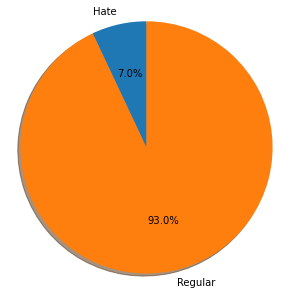

In [5]:
fu.visual_class( ['Hate', 'Regular'], [len(train[train.label == 1]), len(train[train.label == 0])])

Extremely unbalanced data set which we will try to balance later on using RandomOverSampler and see how it affects Naive Bias and Logistic Regression models performances.

### Splitting the data into train and test:

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train['tweet'], train['label'],test_size=0.15, random_state=4)

In [7]:
# Saving the original x train and y train
x_train_org = x_train.copy()
y_train_org = y_train.copy()

In [8]:
print('The number of tweets is:')
print(x_train.shape)
print('**********************************************')
print('The percentage of the hate comments in the data set is:')
print(round((sum(y_train_org)/len(y_train_org))*100), '%')

The number of tweets is:
(27167,)
**********************************************
The percentage of the hate comments in the data set is:
7 %


## Applying oversampling method to increase the number of the hate tweets:

Transforming series into arrays for oversampling methods:

In [9]:
data_len = x_train.shape[0]
x_train = x_train.to_numpy()
x_train.shape = (27167, 1)
y_train = y_train.to_numpy()

In [10]:
over = RandomOverSampler(sampling_strategy=0.5)
x_train, y_train = over.fit_resample(x_train, y_train)

In [11]:
print('The number of tweets is:')
print(x_train.shape)
print('**********************************************')
print('The percentage of the hate comments has been increased to:')
print(round((sum(y_train)/len(y_train)*100)), '%' )

The number of tweets is:
(37900, 1)
**********************************************
The percentage of the hate comments has been increased to:
33.0 %


In [12]:
#Creating a list preprocessed tweets:
prepro_texts = [fu.prepro_tweet(t[0]) for t in x_train]

In [13]:
#Separate hate and normal tweets
normal_ind = np.where(y_train == 0)
hate_ind = np.where(y_train == 1)
normal_tweets = [prepro_texts[i] for i in normal_ind[0]]
hate_tweets = [prepro_texts[i] for i in hate_ind[0]]

### Visualizing the new class balance:

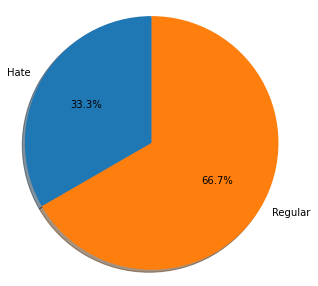

In [14]:
fu.visual_class( ['Hate', 'Regular'], [len(hate_tweets), len(normal_tweets)])

### Word frequencies within the classes:

In [15]:
#Word frequencies per label using Counter:
word_freq_t = Counter(chain.from_iterable(list(prepro_texts)))
total = word_freq_t.most_common()

word_freq_n = Counter(chain.from_iterable(list(normal_tweets)))
normal = word_freq_n.most_common()

word_freq_h = Counter(chain.from_iterable(list(hate_tweets)))
hate = word_freq_h.most_common()

In [16]:
normal[:15]

[('love', 2575),
 ('day', 2296),
 ('...', 2097),
 ('happi', 1733),
 ('thank', 1289),
 ('time', 1032),
 ('get', 1024),
 ('u', 968),
 ('go', 954),
 ('life', 917),
 ('like', 861),
 ('posit', 843),
 ('today', 839),
 ("i'm", 831),
 ('make', 816)]

In [17]:
hate[:15]

[('trump', 1048),
 ('...', 938),
 ('like', 866),
 ('white', 849),
 ('black', 843),
 ('libtard', 826),
 ('racist', 608),
 ('polit', 581),
 ('allahsoil', 557),
 ('liber', 536),
 ('peopl', 522),
 ('hate', 479),
 ('obama', 470),
 ('say', 444),
 ('sjw', 430)]

## Visualizing Naive Bayes

As a part of data analysis we will do some data visualization to get some insight into the expected performance of the Naive Bias model.

A visual inspection of the tweets dataset using the Naïve Bayes features using the log-likelihood ratio as a pair of numerical features that can be fed in a machine learning algorithm.

For each tweet, we have calculated the likelihood of the tweet to be positive and the likelihood to be negative. We have calculated in different columns the numerator and denominator of the likelihood ratio in the data_org(imbalanced data) and data(modified data).

### Original Data

In [18]:
#Creating frequency dictiony on the original data:
freqs_org = fu.count_dict(x_train_org, y_train_org)

In [19]:
data_org = fu.tweet_likelihood(freqs_org, y_train_org, x_train_org)

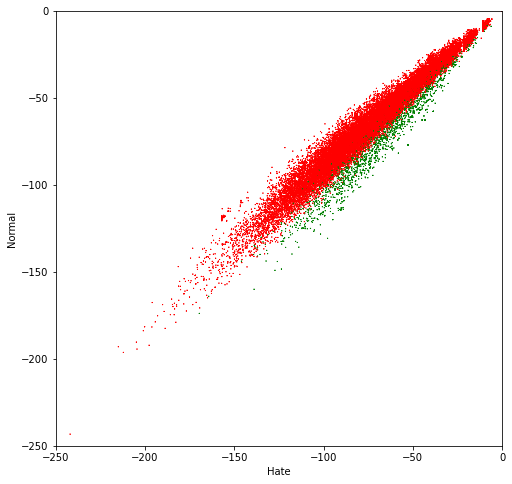

In [20]:
fig, ax = plt.subplots(figsize = (8, 8)) #Create a new figure with a custom size

colors = ['red', 'green'] # Define a color palete

# Color base on sentiment
ax.scatter(data_org.positive, data_org.negative, 
    c=[colors[int(k)] for k in data_org.sentiment], s = 0.1, marker='*')  # Plot a dot for each tweet

# Custom limits for this chart
plt.xlim(-250,0)
plt.ylim(-250,0)

plt.xlabel("Hate") # x-axis label
plt.ylabel("Normal") # y-axis label
plt.show()

In [21]:
data_len = x_train.shape[0]
x_train.shape = (data_len,)

In [22]:
freqs = fu.count_dict(x_train, y_train)
data = fu.tweet_likelihood(freqs, y_train, x_train)

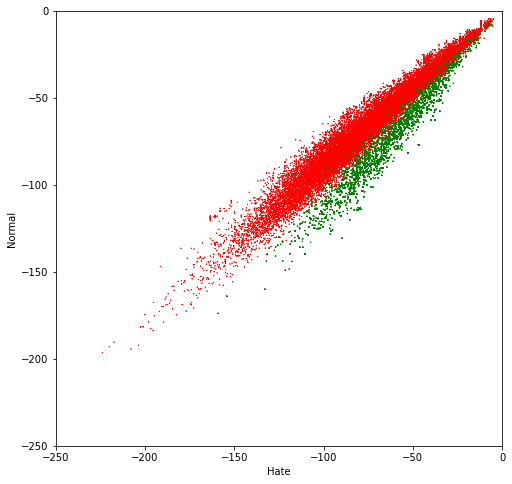

In [23]:
fig, ax = plt.subplots(figsize = (8, 8)) #Create a new figure with a custom size

colors = ['red', 'green'] # Define a color palete

# Color base on sentiment
ax.scatter(data.positive, data.negative, 
    c=[colors[int(k)] for k in data.sentiment], s = 0.1, marker='*')  # Plot a dot for each tweet

# Custom limits for this chart
plt.xlim(-250,0)
plt.ylim(-250,0)

plt.xlabel("Hate") # x-axis label
plt.ylabel("Normal") # y-axis label
plt.show()

In both graphs the two distributions overlap equally in both imbalanced and modified data. So the Naïve Bayes method will perform similarly on both data sets.

### Naive Bias approach with the modified data:

In [24]:
logprior, loglikelihood = fu.train_naive_bayes(freqs, x_train, y_train)
print(logprior)
print(len(loglikelihood))

-0.6931867586574312
29909


Naive Bayes F1 = 0.6619


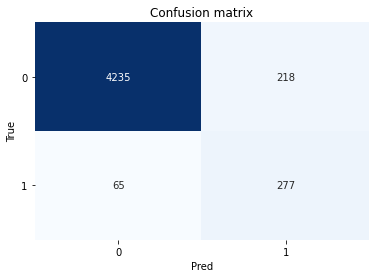

In [25]:
print("Naive Bayes F1 = %0.4f" %
      (fu.test_naive_bayes(x_test, y_test, logprior, loglikelihood, 'f1')))

### Naive Bias approach with the original data:

In [26]:
logprior_org, loglikelihood_org = fu.train_naive_bayes(freqs_org, x_train_org, y_train_org)
print(logprior_org)
print(len(loglikelihood_org))

-2.587645310332937
29909


Naive Bayes F1 = 0.6410


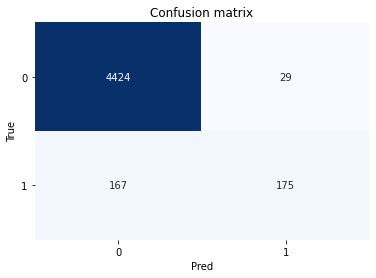

In [27]:
print("Naive Bayes F1 = %0.4f" %
      (fu.test_naive_bayes(x_test, y_test, logprior_org, loglikelihood_org, 'f1')))

The f1 score on imbalanced data has raised slightly from 0.6410 to 0.6715 after we oversampled the data which shows 
some improvement after all.

# Logistic Regression

To inspect the hate and the normal word counts for the most common words per label visually we are going to scatter plot them in the logarithmic scale to take into account the wide discrepancies between the raw counts (e.g. 'Trump' has very high counts in the hate while only 2 in the normal). The red line marks the boundary between normal and hate areas. Words close to the red line can be classified as neutral.

## Original/imbalanced data word counts visualization.

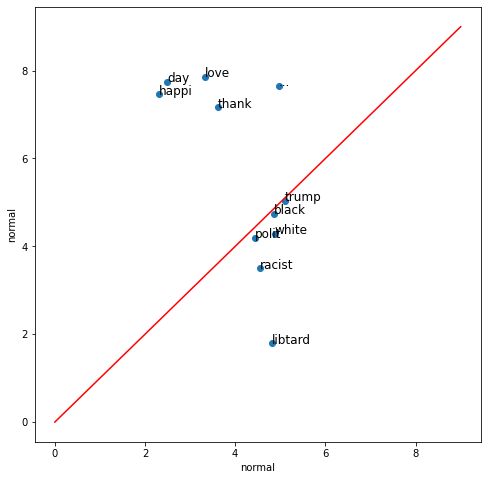

In [28]:
fu.visual_words(['love', 'trump', 'happi', '...', 'white', 'libtard', 'black', 'racist', 'polit','day', 'thank'],
                freqs_org, 'normal', 'hate')

## Modified data word counts visualization.

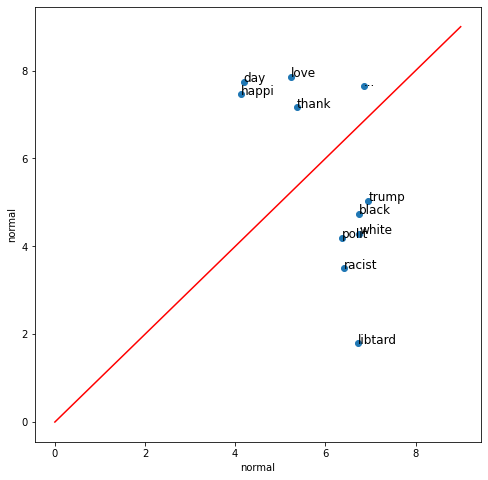

In [29]:
fu.visual_words(['love', 'trump', 'happi', '...', 'white', 'libtard', 'black', 'racist', 'polit','day', 'thank'],
                freqs,  'normal', 'hate')

As a result we can notice that in the imbalanced/original data the most common words are very close to the red line
and therefore viewed by the model as rather neutral while in the more balanced or modified data set they appear to be
more 'negative'.

### Logistic regression using modified data

In [30]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(x_train), 3))
for i in range(len(x_train)):
    X[i, :]= fu.extract_features(list(x_train)[i], freqs)

In [31]:
# training labels corresponding to X
Y = y_train
Y.shape = (data_len, 1)
Y.shape

(37900, 1)

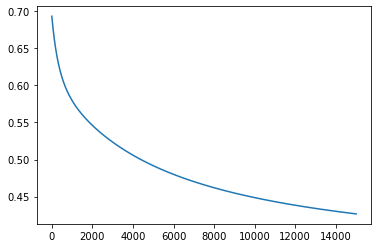

In [32]:
# Apply gradient descent
J, theta = fu.gradientDescent(X, y_train, np.zeros((3, 1)), 1e-9, 15000)

Logistic regression model's F1 = 0.5733


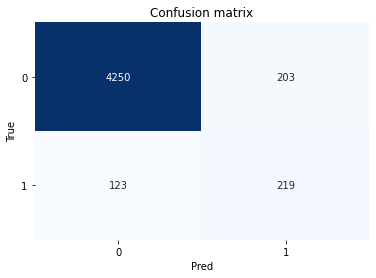

In [33]:
a = fu.accuracy_score(list(x_test), y_test, freqs, theta, 'f1')
print(f"Logistic regression model's F1 = {a:.4f}")

### Logistic regression using the original data

In [34]:
# collect the features 'x' and stack them into a matrix 'X'
X_org = np.zeros((len(x_train_org), 3))
for i in range(len(x_train_org)):
    X_org[i, :]= fu.extract_features(list(x_train_org)[i], freqs_org)

In [35]:
org_len = y_train_org.shape[0]
Y_org = np.array(y_train_org)
Y_org.shape = (org_len, 1)
Y.shape

(37900, 1)

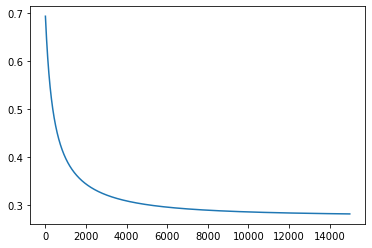

In [36]:
J_org, theta_org = fu.gradientDescent(X_org, Y_org, np.zeros((3, 1)), 1e-9, 15000)

Logistic regression model's F1 = 0.0000


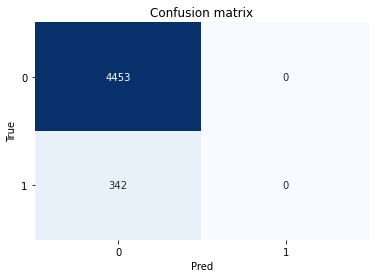

In [37]:
a_org = fu.accuracy_score(list(x_test), y_test, freqs_org, theta_org, 'f1')
print(f"Logistic regression model's F1 = {a_org:.4f}")

The f1 score on the imbalanced data and modified more balanced data is 0 and 0.5760 accordingly  which indicates 
that Logistic Regression does not support imbalanced classification directly and some techniques as oversampling should be performed.